<a href="https://colab.research.google.com/github/Haadi-kp/Image_Colourization/blob/main/Unet_with_pretrained_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from fastai.data.external import untar_data, URLs
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

!pip install fastai==2.4


INFO: pip is looking at multiple versions of fastai to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement torch<1.10,>=1.7.0 (from fastai) (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1)
ERROR: No matching distribution found for torch<1.10,>=1.7.0


In [3]:

coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [4]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


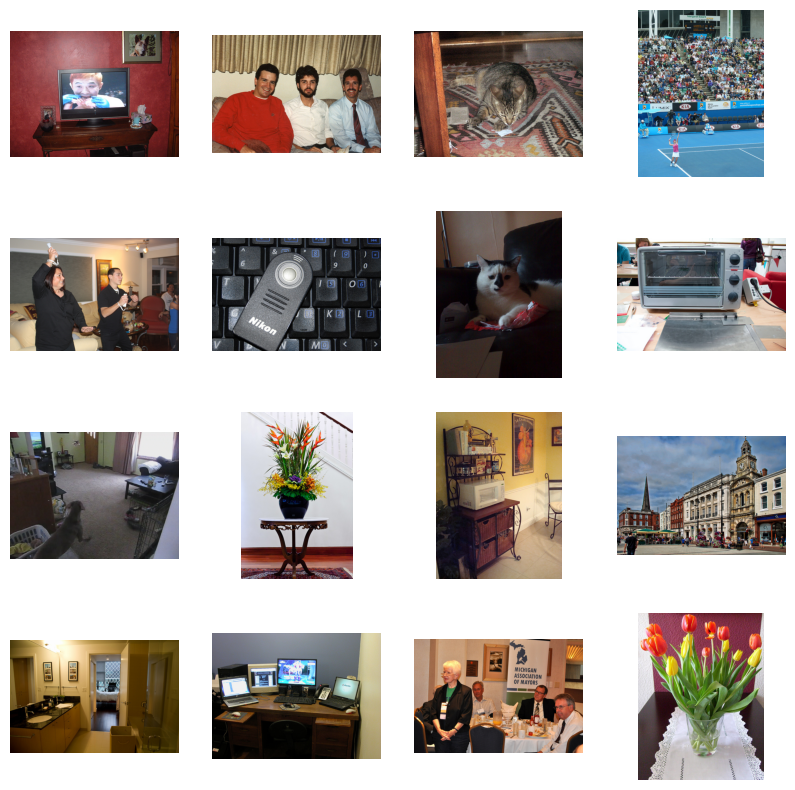

In [5]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [6]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [7]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


In [8]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

In [9]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [10]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [11]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [12]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [13]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [34]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

        self.fake_color = None

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self, L):
        # Compute fake colorization (ab channels) using the Generator
        self.fake_color = self.net_G(L)
        return self.fake_color

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward(self.L)
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [15]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def calculate_psnr(img1, img2):
    """
    Calculate PSNR between two images.
    Args:
        img1: Ground truth image (RGB, range [0, 1]).
        img2: Predicted image (RGB, range [0, 1]).
    Returns:
        PSNR value.
    """
    psnr_value = peak_signal_noise_ratio(img1, img2, data_range=1.0)
    return psnr_value

def calculate_ssim(img1, img2):
    """
    Calculate SSIM between two images.
    Args:
        img1: Ground truth image (RGB, range [0, 1]).
        img2: Predicted image (RGB, range [0, 1]).
    Returns:
        SSIM value.
    """
    # Explicitly set win_size and handle multichannel
    ssim_value = structural_similarity(
        img1, img2, win_size=7, channel_axis=-1, data_range=1.0
    )
    return ssim_value


In [16]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize_with_metrics(model, data, save=True):
    """
    Visualize the outputs and calculate PSNR and SSIM metrics.
    Args:
        model: Trained model.
        data: A batch of data (L and ab channels).
        save: Whether to save the visualization figure.
    """
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()

    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    # Calculate PSNR and SSIM for each image in the batch
    psnr_values = []
    ssim_values = []
    for i in range(len(fake_imgs)):
        psnr = calculate_psnr(real_imgs[i], fake_imgs[i])
        ssim = calculate_ssim(real_imgs[i], fake_imgs[i])
        psnr_values.append(psnr)
        ssim_values.append(ssim)

    # Log average PSNR and SSIM for the batch
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)
    print(f"Avg PSNR: {avg_psnr:.4f}, Avg SSIM: {avg_ssim:.4f}")

    # Plot the visualizations
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()

    if save:
        fig.savefig(f"colorization_with_metrics_{time.time()}.png")


def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [19]:


# # Move model to the appropriate device
# model = MainModel().to(device)

# # Print the model summary
# print("Generator Summary:")
# summary(model.net_G, input_size=(1, 256, 256))  # Input: Grayscale image (1 channel)

# print("\nDiscriminator Summary:")
# summary(model.net_D, input_size=(3, 256, 256))  # Input: L and ab combined (3 channels)


In [21]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Call resnet18 to create a model instance instead of passing the function
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [24]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dl, opt, criterion, 20)


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/20
L1 Loss: 0.08554


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.08271


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/20
L1 Loss: 0.08229


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/20
L1 Loss: 0.08206


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/20
L1 Loss: 0.08189


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/20
L1 Loss: 0.08172


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/20
L1 Loss: 0.08165


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/20
L1 Loss: 0.08139


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/20
L1 Loss: 0.08130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/20
L1 Loss: 0.08116


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/20
L1 Loss: 0.08077


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/20
L1 Loss: 0.08059


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/20
L1 Loss: 0.08019


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/20
L1 Loss: 0.07949


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/20
L1 Loss: 0.07901


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16/20
L1 Loss: 0.07824


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/20
L1 Loss: 0.07722


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18/20
L1 Loss: 0.07672


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19/20
L1 Loss: 0.07540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20/20
L1 Loss: 0.07478


In [25]:
save_path = "/content/drive/MyDrive/saved_model/"
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist
model_file_path = os.path.join(save_path, "pretrained_generator_model.pth")

torch.save(net_G, model_file_path)
print(f"Pretrained generator model saved at: {model_file_path}")

Pretrained generator model saved at: /content/drive/MyDrive/saved_model/pretrained_generator_model.pth


In [30]:
def train_model_with_metrics(model, train_dl, val_dl, epochs, display_every=250, visualize_every=5):
    """
    Train the model and log PSNR and SSIM metrics during training.
    Args:
        model: MainModel instance.
        train_dl: Training dataloader.
        val_dl: Validation dataloader.
        epochs: Number of epochs to train.
        display_every: Interval to display visualizations and metrics.
        visualize_every: Interval to display images and print current epoch.
    """
    data_val = next(iter(val_dl))  # A batch for visualization
    for e in range(epochs):
        loss_meter_dict = create_loss_meters()
        i = 0
        for data in tqdm(train_dl):
            model.setup_input(data)  # Prepare data
            model.optimize()        # Optimize model
            update_losses(model, loss_meter_dict, count=data['L'].size(0))
            i += 1

            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}, Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict)

        # Visualize results at the specified interval
        if (e + 1) % visualize_every == 0:
            print(f"\nDisplaying results for Epoch {e+1}/{epochs}...\n")
            visualize_with_metrics(model, data_val, save=False)


In [ ]:
model_path = "/content/drive/MyDrive/saved_model/2:Unet_colorization_model.pth"

# Load the entire Generator model
net_G = torch.load(model_path, map_location=device)
net_G.eval()  # Set to evaluation mode

# Pass the loaded Generator to MainModel
model = MainModel(net_G=net_G)

# Train the model with metrics and visualizations
train_model_with_metrics(model, train_dl, val_dl, epochs=15)


<ipython-input-35-b22f53c17496>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_G = torch.load(model_path, map_location=device)


model initialized with norm initialization


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1/15, Iteration 250/500
loss_D_fake: 0.60286
loss_D_real: 0.60769
loss_D: 0.60528
loss_G_GAN: 1.05438
loss_G_L1: 8.38153
loss_G: 9.43591

Epoch 1/15, Iteration 500/500
loss_D_fake: 0.57733
loss_D_real: 0.58519
loss_D: 0.58126
loss_G_GAN: 1.12966
loss_G_L1: 8.66924
loss_G: 9.79890


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2/15, Iteration 250/500
loss_D_fake: 0.57583
loss_D_real: 0.58740
loss_D: 0.58161
loss_G_GAN: 1.12350
loss_G_L1: 8.87345
loss_G: 9.99695

Epoch 2/15, Iteration 500/500
loss_D_fake: 0.57863
loss_D_real: 0.59430
loss_D: 0.58647
loss_G_GAN: 1.11657
loss_G_L1: 8.95693
loss_G: 10.07350


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 3/15, Iteration 250/500
loss_D_fake: 0.59485
loss_D_real: 0.61071
loss_D: 0.60278
loss_G_GAN: 1.06019
loss_G_L1: 8.75058
loss_G: 9.81077

Epoch 3/15, Iteration 500/500
loss_D_fake: 0.59454
loss_D_real: 0.61387
loss_D: 0.60420
loss_G_GAN: 1.05555
loss_G_L1: 8.80373
loss_G: 9.85928


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 4/15, Iteration 250/500
loss_D_fake: 0.59473
loss_D_real: 0.62145
loss_D: 0.60809
loss_G_GAN: 1.03130
loss_G_L1: 8.59138
loss_G: 9.62269


In [ ]:
final_model_path = os.path.join(save_path, "final_trained_model.pth")
torch.save(model, final_model_path)
print(f"Final trained model saved at: {final_model_path}")